# Introduction

This activity is copied from a [tutorial](https://www.biggorilla.org/ja/data-preparation-using-koko/index.html) run for the Open Source Big Gorilla Project at the Koko Entity Extraction framework. Completing this tutorial and writing up the results satisfies the requirements for Part I of the Semester Project in DS 320. You may complete this tutorial in your project pairs and you will turn in one for each project pair along with the written report describing what you did and what you learned. 

The aviation field is concerned with safety of airplanes and is doing their best to understand the reason for any potential incidents.  
In this mini-tutorial, suppose you are invited by the aviation authority to analyze all the history aviation incidents.  
Hopefully the results could help reveal potential problems, build more robust aircraft, and impose more effective regulation.  

In the meanwhile, you will learn a variety of data analytical tools, mostly Python-based, by applying them to real data extracted from the Web.

** This mini-tutorial is composed of three parts: **
1. Data extraction: scrape the website about aviation incidents.
2. Data cleaning: clean the extracted data by removing irrelevant information.
4. Entity recognition: use an entity extraction tool Koko, to extract entities from scraped data.
5. Data transformation: convert the unstructured text data into dataframes.

# 1. Data acquisition, extraction, and cleaning

To acquire data, we first need to scrape the text data about aviation incidents from the following Wiki page:  
https://en.wikipedia.org/wiki/List_of_accidents_and_incidents_involving_commercial_aircraft

A number of Python-based tools can be used to scrape the Web, such as [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/) or [Scrapy](https://scrapy.org/).  
Here we use BeautifulSoup for our purpose.  
Suppose we already save the Wiki website as an HTML file. The following code create parse the html file and generate a BeautifulSoup object.

In [58]:
from bs4 import BeautifulSoup

input_html = "source.html"
with open(input_html, "r") as ifile:
    soup = BeautifulSoup(ifile, 'lxml')
    
soup.title.string

'List of accidents and incidents involving commercial aircraft - Wikipedia'

**Task:** Use BeautifulSoup to scrape the Wiki website at https://en.wikipedia.org/wiki/List_of_accidents_and_incidents_involving_commercial_aircraft, and generate a text file containing all the text on the website. The generated file should not contain any html tag.

In [98]:
import re

incidents_cleaned_file = "aviation_incidents_cleaned.txt"

outfile = open(incidents_cleaned_file, "w")

for year_header in soup.find_all("h3"):
    year_span = year_header.find("span", text = re.compile("\d{4}"))
    if not year_span:
        continue
    year = year_span.text.strip().replace("\n", "")
    ul = year_header.find_next("ul")
    for entry in ul.find_all("li"):
        text = entry.text.strip().replace("\n", "")
        date, desc = text.split("–", 1)
        outfile.write(f"On {date.strip()}, {year} – {desc.strip()}\n")
        
outfile.close()

# 3. Entity recognition

Now we are ready to extract interesting and useful information from the cleaned corpus.  

We first create a word cloud as warm-up exercise, and get a general sense of the distribution of words in the corpus.  
Then we will use Koko, an entity extraction tool, to extract airlines and aircrafts from the corpus.

## Word Cloud

The following code generates a wordcloud out of the cleaned corpus.  

Note that we remove common aviation-related words, such as airlines or flight, as they are less informative.

(-0.5, 3599.5, 2699.5, -0.5)

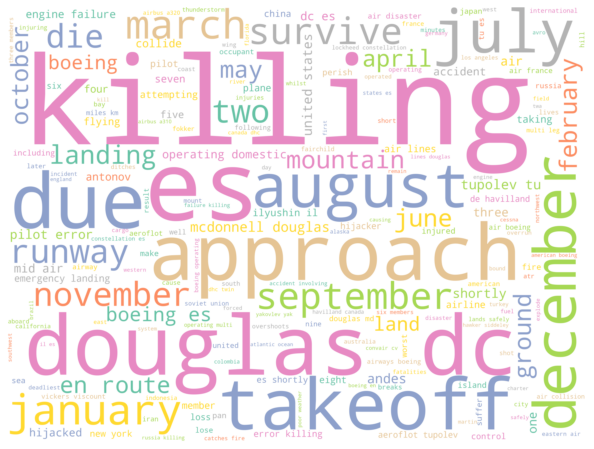

In [99]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, ImageColorGenerator

LIMIT_WORDS = ['airlines flight', 'flight', 'people', 'board', 'international airport', 
               'passenger', 'crew', 'airport', 'aircraft', 'near', 'crash', 'killed']

with open(incidents_cleaned_file) as myfile:
    doc = myfile.read()

text = doc.lower()

for w in LIMIT_WORDS:
    text = text.replace(' ' + w, '')
    text = text.replace(w + ' ', '')

wordcloud = WordCloud(background_color = "white", height = 2700, width = 3600).generate(text)

plt.figure(figsize = (14, 8))
plt.imshow(wordcloud.recolor(colormap = plt.get_cmap('Set2')), interpolation = 'bilinear')
plt.axis("off")

What conclusion can you get from the wordcloud?

## Named Entity Extration

Now suppose we are interested in knowing which airline company has the most incidents.  
How can we get the information from the corpus?  

There are a number of Python-based tools that can extract entities like airline names from text, such as [NLTK](http://www.nltk.org/), [spaCy](https://spacy.io/), [Google NLP](https://cloud.google.com/natural-language/).  
Though these tools are powerful, they do not provide declarative APIs that allow users to extract entities with custom conditions.  
Here we will introduce an entity extraction framework called Koko, which allows the user to specify properties of the extracted entities in a declarative way, and is especially suitable for extracting entities with little evidence in the corpus.

In [ ]:
with open('./koko_queries/airlines_v2.koko', 'r') as file:
    print(file.read())

This query tells Koko to extract entities 'x' from our cleaned aviation data if "x" contains either "Airlines" or "Air".

The weight in each "if" condition (e.g., {0.1} for (str(x) contains "Airlines")) represents the importance of the pattern specified in the condition.
Any appearance of an entity in the data that matches the pattern is considered a piece of evidence.
And each such piece of evidence would increment the entity's score by the condition's weight.

For example, if there's an incident "An Air France flight encountered an emergency situation", this incident is considered as evidence for "Air France" based on the second condition, and 0.1 is added to "Air France"'s score.
In Koko, the score of an entity is at most 1.

Finally, we can specify a threshold in Koko queries.
Only entities scoring higher than the thresold would be returned in the results.
For simplicity, we now put zero as thresold here, which shows all entities that have at least one piece of evidence in the data.

You can find more details about Koko[here](http://pykoko.readthedocs.io/en/latest/).

Let's run the Koko query now to see the results.

Here I use spaCy as the nlp processor for happy moments. Koko could leverage spaCy's APIs for entity extraction.
The extracted entities could be further matched against the conditions in the Koko query to get scored, ranked and filtered.

SpaCy is not the only option. We can also use Koko's default parser or Google NLP API as well.

In [100]:
import koko
import spacy

koko.run('airlines.koko', doc_parser = 'spacy')

Parsed query: extract "aviation_incidents_cleaned.txt" Ents from "x" if
	(str(x) contains "Airlines" { 0.10 }) or
	(str(x) contains "Air" { 0.10 })   
with threshold 0.00


Results:

Entity name                    Entity count         Entity score
United Airlines                26                   1.000000
American Airlines              30                   1.000000
Northwest Airlines             13                   1.000000
Turkish Airlines               16                   1.000000
Japan Airlines                 10                   1.000000
Air France                     8                    0.800000
China Airlines                 8                    0.800000
Indian Airlines                8                    0.800000
Northwest Orient Airlines      7                    0.700000
National Airlines              7                    0.700000
Philippine Airlines            7                    0.700000
Ethiopian Airlines             6                    0.600000
Air Canada          

If we only want to see the top few results, we can set up threshold.

In [101]:
koko.run('airlines_v2.koko', doc_parser = 'spacy')

Parsed query: extract "aviation_incidents_cleaned.txt" Ents from "x" if
	(str(x) contains "Airlines" { 0.10 }) or
	(str(x) contains "Air" { 0.10 })   
with threshold 0.40


Results:

Entity name                    Entity count         Entity score
United Airlines                26                   1.000000
American Airlines              30                   1.000000
Northwest Airlines             13                   1.000000
Turkish Airlines               16                   1.000000
Japan Airlines                 10                   1.000000
Air France                     8                    0.800000
China Airlines                 8                    0.800000
Indian Airlines                8                    0.800000
Northwest Orient Airlines      7                    0.700000
National Airlines              7                    0.700000
Philippine Airlines            7                    0.700000
Ethiopian Airlines             6                    0.600000
Air Canada          

We can also inspect the original texts for each extracted entity.  
To do this, we need to set the parameter "verbose_info" to True when invoking Koko.

In [102]:
koko.run('airlines_v3.koko', doc_parser = 'spacy', verbose_info = True)

Parsed query: extract "aviation_incidents_cleaned.txt" Ents from "x" if
	(str(x) contains "Airlines" { 0.01 }) or
	(str(x) contains "Air" { 0.01 })   
with threshold 0.26


Results:

Entity name                    Entity count         Entity score
American Airlines              30                   0.300000
	 On January 14, 1936 – American Airlines Flight 1, a Douglas DC-2, crashes into a swamp near Goodwin, Arkansas, killing all 17 passengers and crew on board; the cause is never determined.
 

	 On October 30, 1941 – American Airlines Flight 1 a Douglas DC-3, stalls and crashes at Lawrence Station, Ontario, Canada while attempting to find a place to land, killing all 20 on board; the cause of the crash is never determined.
 

	 On October 23, 1942 – American Airlines Flight 28, a Douglas DC-3, crashes near Palm Springs, California, United States, after being struck by a U.S. Army Air Corps Lockheed B-34 bomber; all 12 aboard the airliner die, while the bomber lands safely with minor 

**Task 2:** Find the models of aircrafts that have most incidents in the corpus.

In [110]:
koko.run('aircraft.koko', doc_parser = 'spacy')

Parsed query: extract "aviation_incidents_cleaned.txt" Ents from "x" if
	(str(x) contains "Boeing" { 0.10 }) or
	(str(x) contains "Airbus" { 0.10 }) or
	(str(x) contains "Bombardier" { 0.10 }) or
	(str(x) contains "Douglas" { 0.10 }) or
	("[',', 'a']" (1.00) ~ x { 0.10 }) or
	("[',', 'an']" (1.00) ~ x { 0.10 })   
with threshold 0.40


Results:

Entity name                    Entity count         Entity score
Boeing                         322                  1.000000
Douglas DC-2                   7                    1.000000
Lockheed                       46                   1.000000
Douglas                        13                   1.000000
Douglas DC-3                   16                   1.000000
Douglas DC-4                   25                   1.000000
Douglas DC-6                   14                   1.000000
Vickers                        12                   1.000000
Convair                        13                   1.000000
Vickers Viscount               10     

# 3. Data transformation

Text data are not structured. To facilitate further data processing, it would be better if we convert text into more structured data, such as Dataframes.  

Here we use textual data instead of JSON output of Koko, because Koko's response doesn't include the original texts, but only the sentence ID of the matching sentences.

# From text to Dataframe

We use spaCy and pandas to convert text data into Dataframe.

In [112]:
import pandas as pd
import spacy
import re

nlp = spacy.load('en')

df = pd.DataFrame(columns=['Date', 'Airline', 'Aircraft', 'Location'])
# We could add the field of 'Aircraft'. But that could be tricky.

incidents = []
with open(incidents_cleaned_file) as myfile:
    for line in myfile:
        doc = nlp(line)
        icd = {'Date':'', 'Airline':'', 'Flight':'', 'Location':''}
        for ent in doc.ents:
            if ent.label_ == u'DATE':
                # Get the date
                icd['Date'] = ent.text
            elif ent.label_ == u'ORG':
                # Get the organization
                icd['Airline'] = ent.text                
            elif ent.label_ == u'PRODUCT':
                # Get the flight number
                if re.search(r'flight', ent.text, re.I):
                    icd['Flight'] = ent.text
            elif ent.label_ == u'GPE':
                # Get the location
                icd['Location'] += '' + ent.text
        incidents.append(icd)

df = pd.DataFrame(incidents)
df.head(5)

,Airline,Date,Flight,Location
0,Illinois Trust and Savings Building,"July 21, 1919",,ChicagoIllinois
1,,"14, 15",,VeronaItalyVeniceTaliedoMilan
2,Handley Page,"December 14, 1920",,London
3,CGEA,"April 7, 1922",,F-GEADPicardieFrance
4,Air Union,"May 14, 1923",,MonsuresSommeFrance


In [113]:
df.tail(5)

,Airline,Date,Flight,Location
1249,Saab,the next day,PenAir Flight 3296,AnchorageAlaskaUnited StatesAmaknak Island
1250,,"November 24, 2019",,the Democratic Republic of the Congo
1251,,"December 27, 2019",Bek Air Flight 2100,Kazakhstan
1252,Boeing,"January 8, 2020",Flight 752,KyivUkraineTehranIran
1253,Boeing,"January 14, 2020",,


** Task **: Extract models of aircrafts and add them into the dataframe.
You can use the following website for reference of aircraft models: 
https://en.wikipedia.org/wiki/List_of_aircraft_by_date_and_usage_category

In [118]:
incidents2 = []
with open(incidents_cleaned_file) as myfile:
    for line in myfile:
        doc = nlp(line)
        icd = {'Date':'', 'Airline':'', 'Flight':'', 'Location':'', "Aircraft": ""}
        for ent in doc.ents:
            if ent.label_ == u'DATE':
                # Get the date
                icd['Date'] = ent.text
            elif ent.label_ == u'ORG':
                # Get the organization
                icd['Airline'] = ent.text                
            elif ent.label_ == u'PRODUCT':
                # Get the flight number
                if re.search(r'flight', ent.text, re.I):
                    icd['Flight'] = ent.text
                else:
                    icd["Aircraft"] = ent.text
            elif ent.label_ == u'GPE':
                # Get the location
                icd['Location'] += '' + ent.text
        incidents2.append(icd)

df2 = pd.DataFrame(incidents2)
df2.head(5)

,Aircraft,Airline,Date,Flight,Location
0,,Illinois Trust and Savings Building,"July 21, 1919",,ChicagoIllinois
1,,,"14, 15",,VeronaItalyVeniceTaliedoMilan
2,,Handley Page,"December 14, 1920",,London
3,,CGEA,"April 7, 1922",,F-GEADPicardieFrance
4,,Air Union,"May 14, 1923",,MonsuresSommeFrance


In [119]:
df2.tail(5)

,Aircraft,Airline,Date,Flight,Location
1249,,Saab,the next day,PenAir Flight 3296,AnchorageAlaskaUnited StatesAmaknak Island
1250,,,"November 24, 2019",,the Democratic Republic of the Congo
1251,,,"December 27, 2019",Bek Air Flight 2100,Kazakhstan
1252,737-800,Boeing,"January 8, 2020",Flight 752,KyivUkraineTehranIran
1253,777-200,Boeing,"January 14, 2020",,


In [120]:
df2.to_csv("source1.csv")